In [ ]:
# This notebook produces georeferenced images and plots sample locations over the images. 
# The images can be used to qualitatively assess how our predicted HAB extent matches up with manual samples.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import datetime

In [ ]:
#The following data is from NOAA monitoring  

#Western Lake Erie 
#web link = https://www.glerl.noaa.gov/res/HABs_and_Hypoxia/wle-weekly-current/ 
#csv file link = https://www.glerl.noaa.gov/res/HABs_and_Hypoxia/wle-weekly-current/2022_WLE_Weekly_Datashare_CSV.csv

#Saginaw Bay
#csv file link = https://www.glerl.noaa.gov/res/HABs_and_Hypoxia/sb-weekly-current/SB_Weekly_Datashare_CSV.csv
#website link =  https://www.glerl.noaa.gov/res/HABs_and_Hypoxia/sb-weekly-current/

#csv files contain data on microcystin (the toxin produced by cyanobacteria) concentrations 
#as well as some other related parameters.

In [ ]:
# import cyanobacteria sampling data 
!wget https://www.glerl.noaa.gov/res/HABs_and_Hypoxia/wle-weekly-current/2022_WLE_Weekly_Datashare_CSV.csv

--2023-04-04 19:50:01--  https://www.glerl.noaa.gov/res/HABs_and_Hypoxia/wle-weekly-current/2022_WLE_Weekly_Datashare_CSV.csv
Resolving www.glerl.noaa.gov (www.glerl.noaa.gov)... 192.94.173.55, 2610:20:900d:4010::55
Connecting to www.glerl.noaa.gov (www.glerl.noaa.gov)|192.94.173.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41254 (40K) [text/csv]
Saving to: ‘2022_WLE_Weekly_Datashare_CSV.csv’

2022_WLE_Weekly_Dat 100%[===================>]  40.29K  --.-KB/s    in 0.1s    

2023-04-04 19:50:01 (360 KB/s) - ‘2022_WLE_Weekly_Datashare_CSV.csv’ saved [41254/41254]



In [ ]:
# read in csv
df = pd.read_csv('2022_WLE_Weekly_Datashare_CSV.csv')
df.shape

(234, 26)

In [ ]:
# Select the columns we are interested in and drop NaN rows

df = df[['Date', 'Lat_deg', 'Long_deg', 'Dissolved_Microcystin_ugL-1']]
df = df.dropna()
#df.Date = pd.to_datetime(df.Date)
print(df.shape)
#print(df.dtypes)
df.head(1)

(152, 4)


,Date,Lat_deg,Long_deg,Dissolved_Microcystin_ugL-1
0,4/25/2022,41.7621,-83.33005,0.25


In [ ]:
# add a column for dissolved microcystin presence or absence

micro_list = df['Dissolved_Microcystin_ugL-1'].tolist()
pres_abs = []
for val in micro_list:
  if val == 'bdl':
    pres = 0
  else:
    pres = 1
  pres_abs.append(pres)

df['label'] = pres_abs

df.head()

,Date,Lat_deg,Long_deg,Dissolved_Microcystin_ugL-1,label
0,4/25/2022,41.762100,-83.330050,0.25,1
2,4/25/2022,41.826617,-83.195133,bdl,0
3,4/25/2022,41.705000,-83.385500,0.2,1
4,4/25/2022,41.834350,-83.359283,0.13,1
7,4/25/2022,41.702750,-83.254383,0.17,1


In [ ]:
# function for getting locations with a positive detection for a specific date

def get_samples_date(df, target_date, lake_e=True):
  df_date = df[df['Date'] == target_date] 
  df_date = df_date[df_date['label'] == 1]  #use this to get only positive detections
  if lake_e is True:
    df_date = df_date[df_date['Long_deg'] < -82] # drop samples in eastern Lake Erie
  return df_date


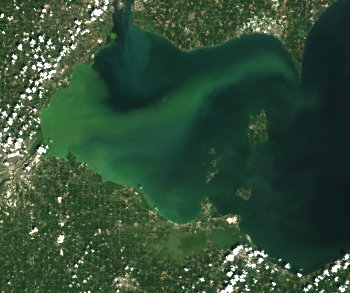

In [ ]:
#open and view a color image

png_path = '/content/_sentinel-3.2022231.0819.1601C.b.L3.LE3.v951T202211_1_3.truecolor.WesternLErie.png'

img = Image.open(png_path)
img.show()

In [ ]:
img.size

(350, 293)

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 38.0 MB/s eta 0:00:00


In [ ]:
# georefrencing an image using cords for north, south, east, and west extents
#input cords must be in EPSG:4326 (WGS84 - World Geodetic System 1984, commonly used in GPS)

import rasterio

def make_geo(north, south, east, west, path):
  dataset = rasterio.open(path, 'r')
  bands = [1, 2, 3]
  data = dataset.read(bands)
  output_file_path = path[:-3] + '_geo.tiff'

  transform = rasterio.transform.from_bounds(west, south, east, north, data.shape[1], data.shape[2])
  crs = {'init': 'epsg:4326'}

  _, width, height = data.shape
  with rasterio.open(output_file_path, 'w', driver='GTiff',
                   width=width, height=height,
                   count=3, dtype=data.dtype, nodata=0,
                   transform=transform, crs=crs) as dst:
    dst.write(data, indexes=bands)

In [ ]:
#[-83.684312, 42.107459, -82.296531, 41.334801] estimated cords
north = 42.107459
south = 41.294801
east = -82.296531
west = -83.584312
path = png_path

make_geo(north, south, east, west, path)


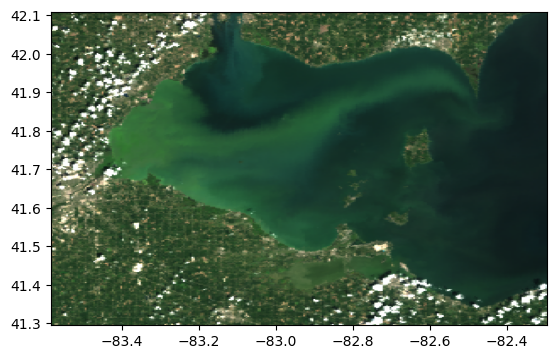

<Axes: >

In [ ]:
# open and view the new georefrenced image

from rasterio.plot import show
geo_img_path = '/content/_sentinel-3.2022231.0819.1601C.b.L3.LE3.v951T202211_1_3.truecolor.WesternLErie._geo.tiff'
geo_img = rasterio.open(geo_img_path)
show(geo_img)

In [ ]:
target_date = '8/17/2022'  #samples are collected approx weekly so match to closest
df_date = get_samples_date(df, target_date, lake_e=True)

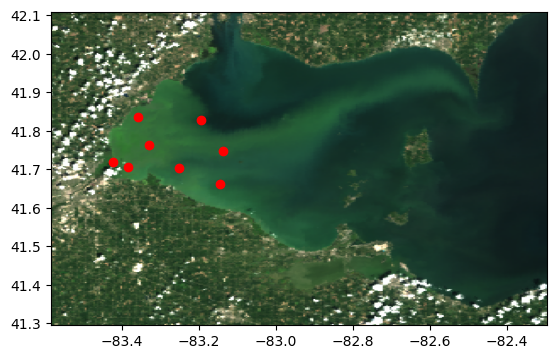

In [ ]:
# plot sample locations with positive detections over image

f,ax = plt.subplots()
rasterio.plot.show(geo_img.read(), ax = ax, transform = geo_img.transform)
x= df_date['Long_deg']
y= df_date['Lat_deg']
plt.scatter(x, y, c='red')

In [ ]:
# georefrencing a stego prediction image using cords for north, south, east, and west extents

stego_path = '/content/_sentinel-3.2022231.0819.1601C.b.L3.LE3.v951T202211_1_3.truecolor.WesternLErie.lin_stego_pred.png'

north = 42.127459
south = 41.294801
east = -82.496531
west = -83.501312
path = stego_path

make_geo(north, south, east, west, path)

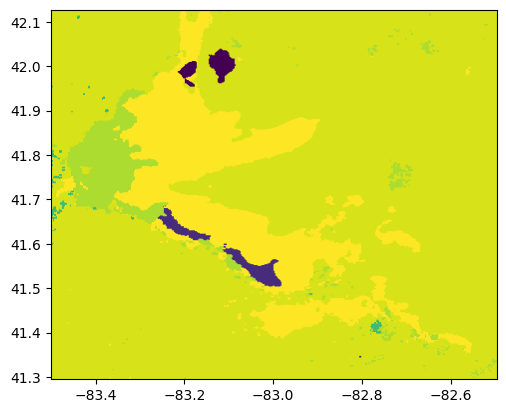

<Axes: >

In [ ]:
stego_geo_path = '/content/_sentinel-3.2022231.0819.1601C.b.L3.LE3.v951T202211_1_3.truecolor.WesternLErie.lin_stego_pred._geo.tiff'
geo_img = rasterio.open(stego_geo_path)
show(geo_img)

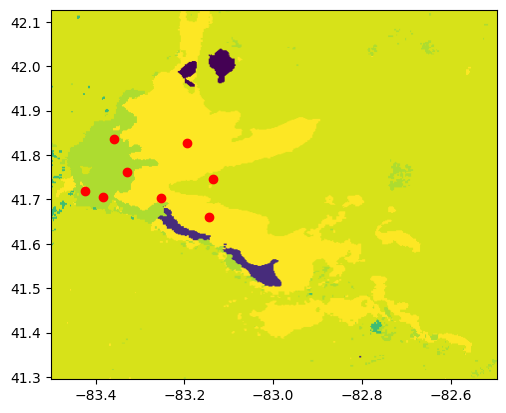

In [ ]:
f,ax = plt.subplots()
rasterio.plot.show(geo_img.read(), ax = ax, transform = geo_img.transform)
x= df_date['Long_deg']
y= df_date['Lat_deg']
plt.scatter(x, y, c='red')